In [110]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [116]:
df = pd.read_csv("imputed_data_final.csv")
df = df[df.columns[4:]]
df.head(5)

,Year,EVI,Height,HSUS,Immigration,Life Expectancy,Polarization,Wage GDP Ratio,fatalities,riot_economic,...,ne_count,ok_count,hi_count,sd_count,nd_count,ia_count,ak_count,NA_count,Population,Political Instability
0,1782,25.27862,173.108454,19.258893,1.496999,55.768842,0.371811,1.090890,1.0,0,...,0,0,0,0,0,0,0,0,2.970621e+06,-1.088771
1,1784,25.27862,173.063703,19.004489,1.496999,56.035361,0.371811,1.090890,9.0,4,...,0,0,0,0,0,0,0,0,3.188095e+06,1.143161
2,1787,25.27862,172.974200,19.098354,1.496999,56.071185,0.371811,1.090890,20.0,0,...,0,0,0,0,0,0,0,0,3.553406e+06,2.099389
3,1788,25.27862,172.929448,18.675441,1.496999,56.126853,0.371811,1.091615,3.0,0,...,0,0,0,0,0,0,0,0,3.677840e+06,2.163410
4,1791,26.45349,172.892156,18.544447,1.566766,56.063206,0.532692,1.146261,1.0,1,...,0,0,0,0,0,0,0,0,4.056153e+06,1.777819


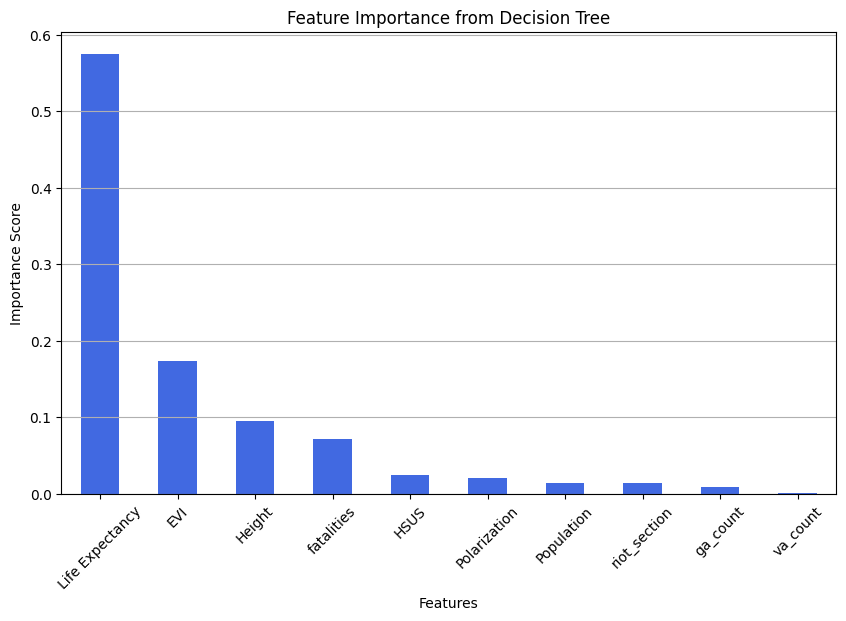

Top 5 Features: ['Life Expectancy', 'EVI', 'Height', 'fatalities', 'HSUS']


In [117]:
df = df.select_dtypes(include=[np.number]).dropna()
X = df.drop(columns=["Political Instability"])
y = df["Political Instability"]

dtree = DecisionTreeRegressor(
    max_depth=5,  # Limit depth to avoid overfitting
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dtree.fit(X, y)

feature_importance = pd.Series(dtree.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importance.head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='bar', color='royalblue')
plt.title("Feature Importance from Decision Tree")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# Select the top 5 features
top_5_features = top_features.head(5).index.tolist()
print("Top 5 Features:", top_5_features)

In [118]:
top_5_features.append("Year")
X_selected = X[top_5_features]
X_selected

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=12)

X_train_scaled = scaler.fit_transform(X_train.drop(columns=["Year"]))
X_test_scaled = scaler.transform(X_test.drop(columns=["Year"]))

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5),
    "Lasso Regression": LassoCV(alphas=np.logspace(-3, 3, 10), cv=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Store results
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)  

    results[name] = {"MSE": mse, "R² Score": r2, "MAE": mae}

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


                        MSE  R² Score       MAE
Linear Regression  0.693485  0.657659  0.598245
Ridge Regression   0.706058  0.651452  0.599412
Lasso Regression   0.697652  0.655602  0.597244
Random Forest      0.295269  0.854239  0.370528
Gradient Boosting  0.318941  0.842554  0.395397


In [119]:
best_model = results_df.sort_values("MSE").index[0]
print(f"Best Model: {best_model}")

Best Model: Random Forest


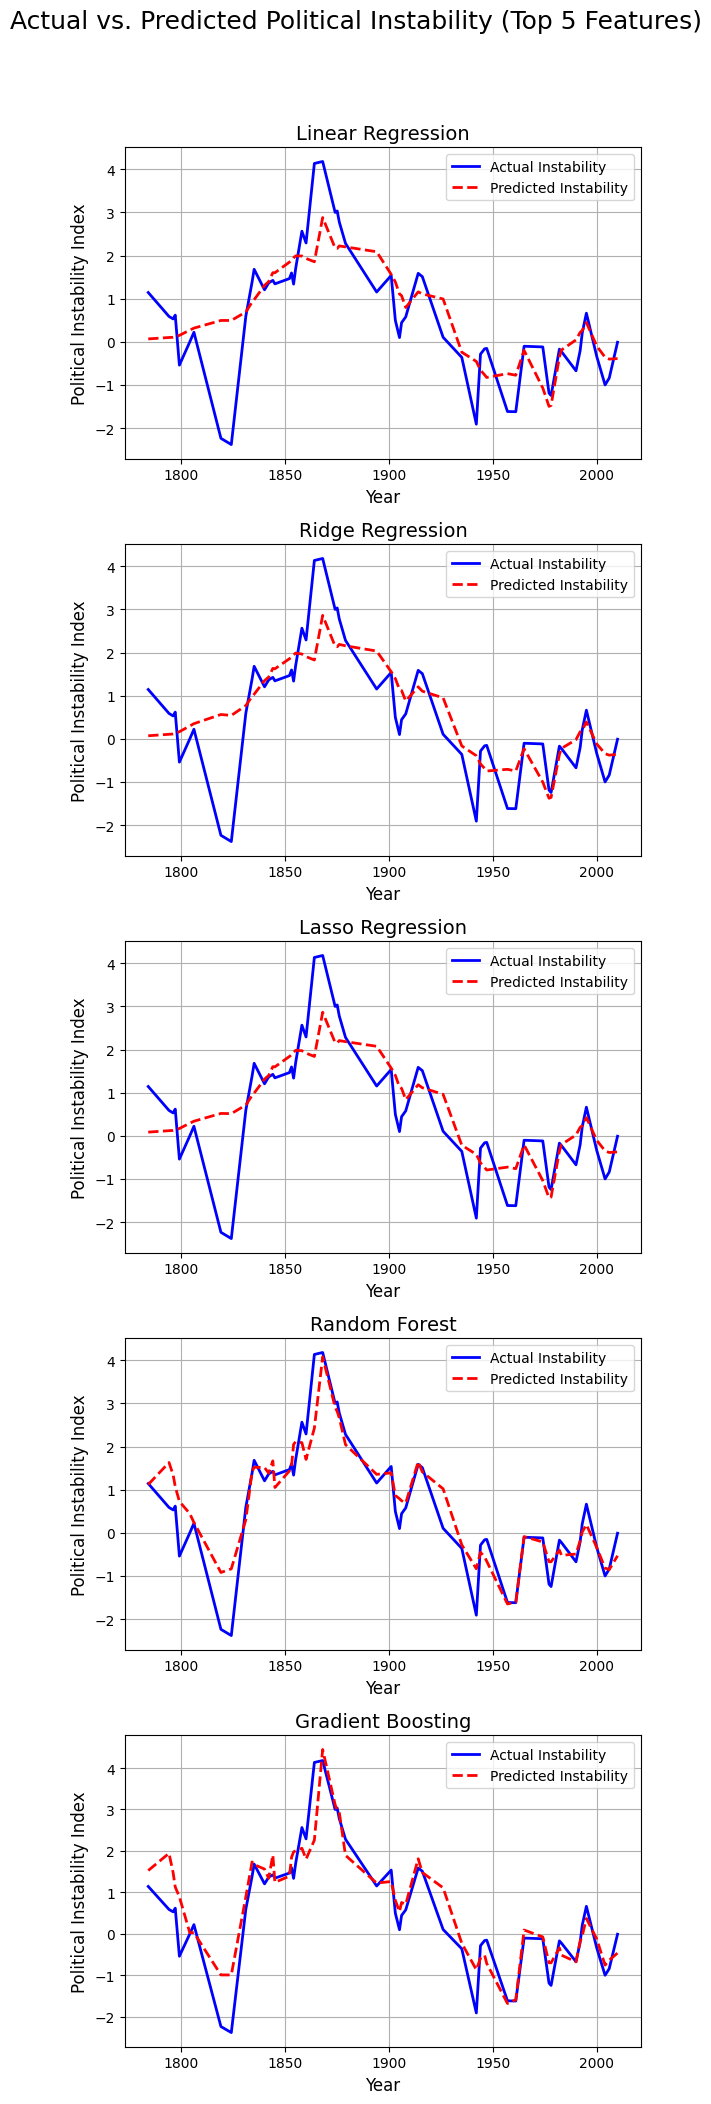

In [120]:
model_predictions = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    df_test_results = pd.DataFrame({
        "Year": X_test["Year"],  # Year for plotting
        "Actual": y_test,
        "Predicted": y_pred
    }).sort_values(by="Year")  
    
    model_predictions[name] = df_test_results

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 20))  
axes = axes.flatten()  

for i, (name, df_test_results) in enumerate(model_predictions.items()):
    axes[i].plot(df_test_results["Year"], df_test_results["Actual"], label="Actual Instability", color="blue", linewidth=2)
    axes[i].plot(df_test_results["Year"], df_test_results["Predicted"], label="Predicted Instability", color="red", linestyle="dashed", linewidth=2)

    # Labels & title
    axes[i].set_xlabel("Year", fontsize=12)
    axes[i].set_ylabel("Political Instability Index", fontsize=12)
    axes[i].set_title(f"{name}", fontsize=14)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.suptitle("Actual vs. Predicted Political Instability (Top 5 Features)", fontsize=18, y=1.05)

# Show plot
plt.show()
